# Desafio de Time Series

Lucho Nov| 2025 <br>
Coconut by Harry Nilsson <br>

## Introduccion
Este análisis examina el comportamiento histórico del par EUR/GBP desde enero 2020 hasta diciembre 2024, utilizando datos de Alpha Vantage.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Import Dataset

Antes de importar los datos, se llevará a cabo un proceso de limpieza y preparación con el objetivo de asegurar su calidad y consistencia. En primer lugar, los valores faltantes se imputarán utilizando el último valor registrado (forward fill), siguiendo buenas prácticas de preprocesamiento para mantener la coherencia temporal y evitar sesgos en el análisis.

Asimismo, se eliminarán los registros duplicados, ya que no aportan información adicional y pueden afectar tanto la precisión del análisis como el rendimiento y escalabilidad de los procesos posteriores. Este paso es fundamental para garantizar una base de datos confiable y optimizada, facilitando así el flujo de trabajo entre la ingeniería y la ciencia de datos.

In [2]:
file_path = r"E:\data_lightstorm\data\raw\EURGBP_2020_2024.csv"

# Cargar datos con manejo de errores
try:
    df = (
        pd.read_csv(file_path)
        .drop_duplicates()
        .fillna(method='ffill')
    )
    df_raw = df.copy()

    # Convertir columna 'date' a formato datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Verificar fechas inválidas
    invalid_dates = df['date'].isna().sum()
    if invalid_dates > 0:
        print(f"⚠️ {invalid_dates} filas con fecha inválida eliminadas.")
        df = df.dropna(subset=['date'])

    display(df.head())

except FileNotFoundError:
    print(f"❌ Archivo no encontrado: {file_path}")
except Exception as e:
    print(f"⚠️ Error al cargar el archivo: {e}")

,date,open,high,low,close
0,2020-01-01,0.84548,0.84832,0.84505,0.84586
1,2020-01-02,0.84588,0.85142,0.84560,0.85010
2,2020-01-03,0.85000,0.85431,0.84920,0.85270
3,2020-01-06,0.85350,0.85450,0.84910,0.84966
4,2020-01-07,0.84950,0.85270,0.84650,0.84940


In [3]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,1305,2022-07-01 19:12:00,2020-01-01 00:00:00,2021-04-01 00:00:00,2022-07-01 00:00:00,2023-10-02 00:00:00,2024-12-31 00:00:00,NaN
open,1305.0,0.863461,0.82299,0.84898,0.85883,0.8761,0.93894,0.021573
high,1305.0,0.866298,0.82514,0.8516,0.86127,0.87904,0.94996,0.022241
low,1305.0,0.860901,0.8201,0.84681,0.85673,0.8728,0.9208,0.020918
close,1305.0,0.863477,0.823,0.84901,0.8588,0.87603,0.93894,0.021569


## Analisis Exploratorio de Datos (EDA)

Luego del **resumen estadístico descriptivo**, se procedió a la **generación de los gráficos previstos** dentro del análisis.  
Durante esta etapa se incorporaron nuevas variables con el objetivo de **ampliar la perspectiva temporal y contextual de los datos**.

#### Variables añadidas

- **Volumen de transacciones (`volume`)**
- **Semana (`week`)**
- **Mes (`month`)**
- **Año (`year`)**

La inclusión de estas dimensiones permite **estudiar el comportamiento del activo a distintas escalas temporales** y **analizar la relación entre volumen y volatilidad**, así como la posible **estacionalidad de los retornos**.  

Estas variables son **fundamentales para comprender la dinámica de los datos** desde un enfoque **temporal y multivariable**.

En la siguiente tabla se resumen las dos variables clave utilizadas para evaluar el desempeño del activo:

| **Variable** | **Qué Representa** | **Por Qué se Usa** |
|---------------|--------------------|--------------------|
| `return` | Cambio porcentual diario en el precio de cierre. | Permite medir la volatilidad, analizar correlaciones y estimar el ruido presente en la serie temporal. |
| `cum_return` | Ganancia total acumulada desde el inicio del período. | Se utiliza para identificar tendencias (alcistas o bajistas) a lo largo del tiempo y evaluar el rendimiento total de la inversión. |



Lógica de Cálculo

El cálculo de ambas variables se realizó de la siguiente forma:

1. Retorno Diario



La fórmula matemática equivalente es:

$$
\text{return}_t = \frac{\text{Close}_t - \text{Close}_{t-1}}{\text{Close}_{t-1}}
$$

Donde:

- $\text{Close}_t$: Precio de cierre del día actual.  
- $\text{Close}_{t-1}$: Precio de cierre del día anterior.

Esta variable representa el **rendimiento porcentual diario**, es decir, cuánto varía el precio de cierre de un día respecto al anterior.

df["return"] = df["close"].pct_change() python

2. Ganancia Total

$$
\text{cum\_return}_t = \prod_{i=1}^{t} (1 + \text{return}_i) - 1
$$

Acumula los retornos diarios para mostrar el **rendimiento total** desde el inicio del período analizado.  
Es una medida útil para **visualizar la evolución global del activo** y determinar si presenta un comportamiento **alcista, bajista o lateral**.


df["cum_return"] = (1 + df["return"].fillna(0)).cumprod() - 1

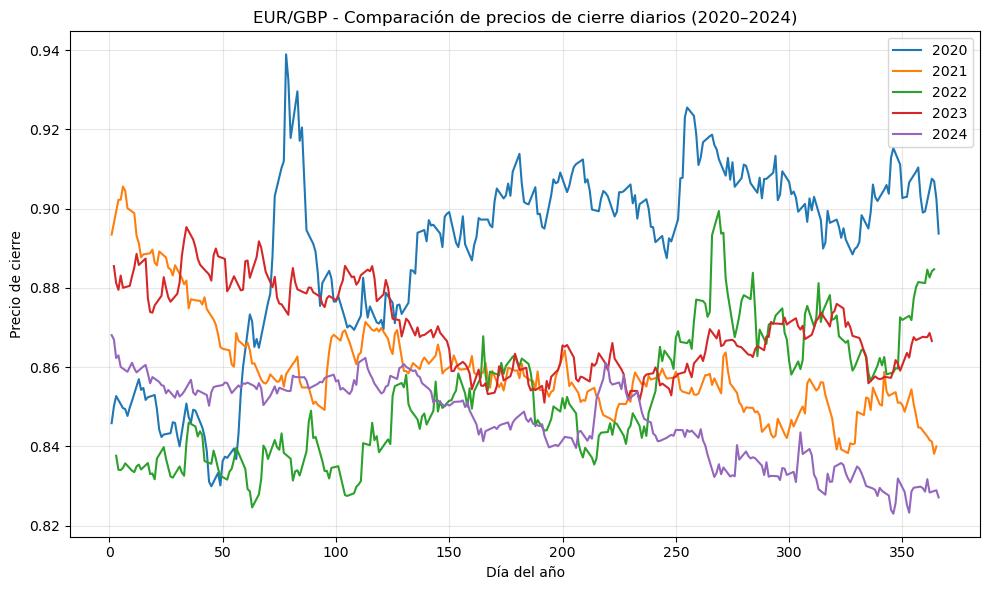

In [4]:
df["year"] = df["date"].dt.year
df["day_of_year"] = df["date"].dt.dayofyear

plt.figure(figsize=(10,6))
for year, group in df.groupby("year"):
    plt.plot(group["day_of_year"], group["close"], label=str(year))

plt.title("EUR/GBP - Comparación de precios de cierre diarios (2020–2024)")
plt.xlabel("Día del año")
plt.ylabel("Precio de cierre")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

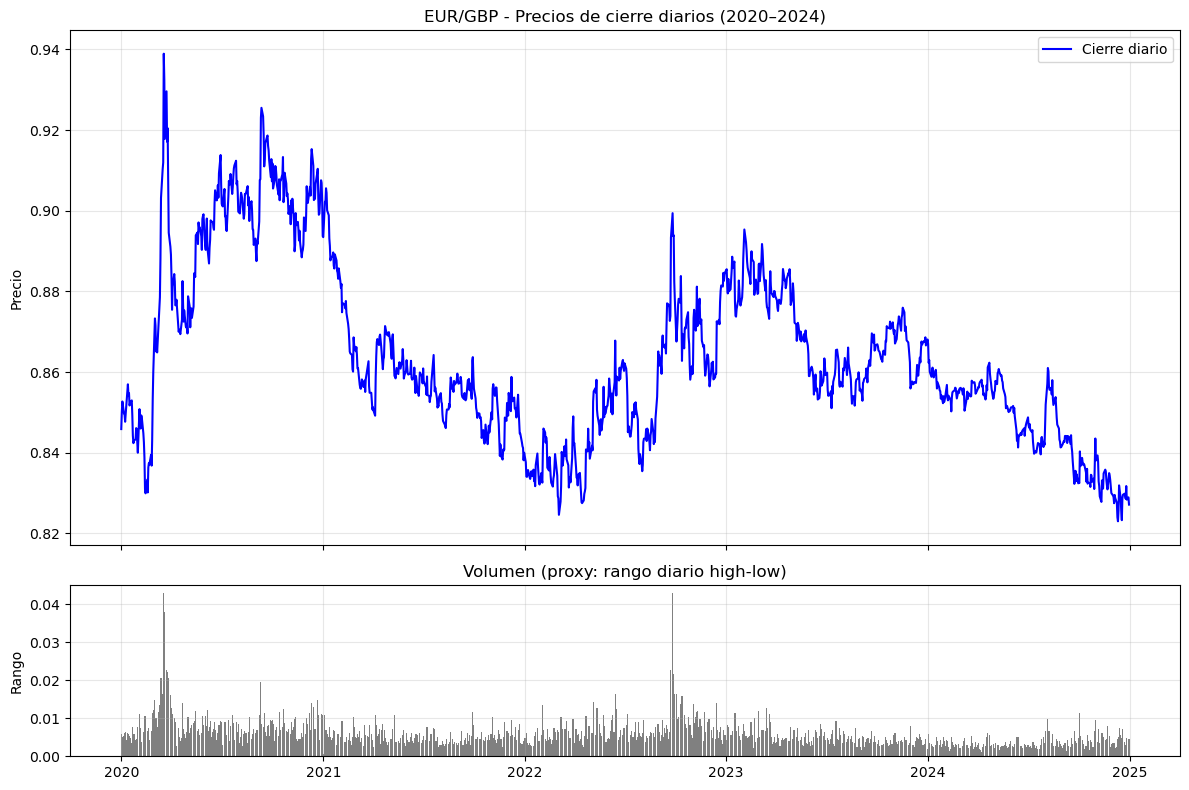

In [5]:
df["volume_proxy"] = df["high"] - df["low"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), 
                               gridspec_kw={'height_ratios': [3, 1]},
                               sharex=True)

# Subplot superior: precios de cierre
ax1.plot(df["date"], df["close"], color="blue", label="Cierre diario")
ax1.set_title("EUR/GBP - Precios de cierre diarios (2020–2024)")
ax1.set_ylabel("Precio")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot inferior: volumen proxy
ax2.bar(df["date"], df["volume_proxy"], color="gray", width=2)
ax2.set_title("Volumen (proxy: rango diario high-low)")
ax2.set_ylabel("Rango")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


📊 --- Análisis exploratorio EUR/GBP ---
Rango temporal: 2020-01-01 → 2024-12-31
Número de registros: 1305

Estadísticas descriptivas (Close):
count    1305.000000
mean        0.863477
std         0.021569
min         0.823000
25%         0.849010
50%         0.858800
75%         0.876030
max         0.938940
Name: close, dtype: float64

Volatilidad promedio por año:
year
2020    0.023350
2021    0.012786
2022    0.016065
2023    0.010664
2024    0.010520
Name: close, dtype: float64

Resumen anual (min, max, mean):
          min      max      mean
year                            
2020  0.82993  0.93894  0.889364
2021  0.83813  0.90557  0.859551
2022  0.82460  0.89940  0.852447
2023  0.85104  0.89535  0.869521
2024  0.82300  0.86808  0.846451


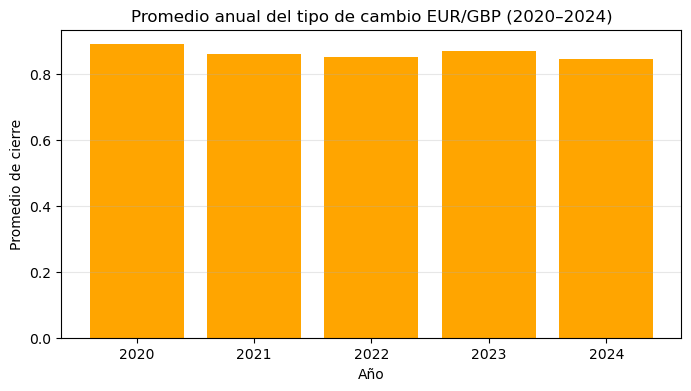

In [6]:
print("\n📊 --- Análisis exploratorio EUR/GBP ---")
print("Rango temporal:", df["date"].min().date(), "→", df["date"].max().date())
print("Número de registros:", len(df))

# Estadísticas descriptivas
print("\nEstadísticas descriptivas (Close):")
print(df["close"].describe())

# Volatilidad anual
volatility = df.groupby("year")["close"].std()
print("\nVolatilidad promedio por año:")
print(volatility)

# Máximos y mínimos por año
yearly_summary = df.groupby("year")["close"].agg(["min", "max", "mean"])
print("\nResumen anual (min, max, mean):")
print(yearly_summary)

# --- Visualización de medias anuales ---
plt.figure(figsize=(8,4))
plt.bar(yearly_summary.index, yearly_summary["mean"], color="orange")
plt.title("Promedio anual del tipo de cambio EUR/GBP (2020–2024)")
plt.xlabel("Año")
plt.ylabel("Promedio de cierre")
plt.grid(axis="y", alpha=0.3)
plt.show()

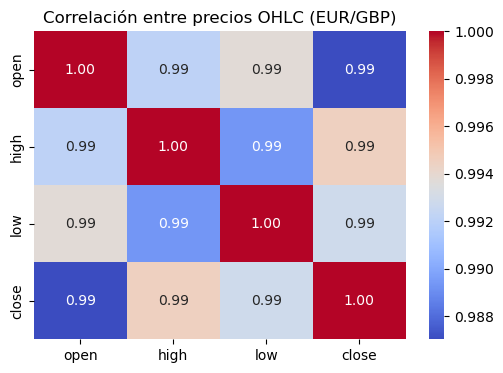

In [7]:
plt.figure(figsize=(6, 4))
sns.heatmap(df[["open","high","low","close"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre precios OHLC (EUR/GBP)")
plt.show()

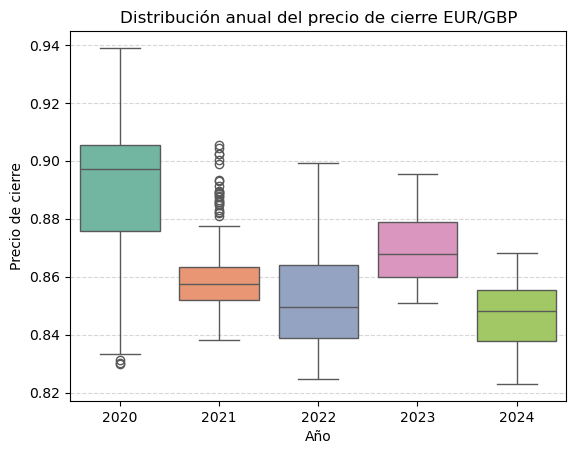

In [8]:
sns.boxplot(x="year", y="close", data=df, palette="Set2")
plt.title("Distribución anual del precio de cierre EUR/GBP")
plt.xlabel("Año")
plt.ylabel("Precio de cierre")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.show()


In [9]:
# Crear retornos y retorno acumulado
df["return"] = df["close"].pct_change()
df["cum_return"] = (1 + df["return"].fillna(0)).cumprod() - 1

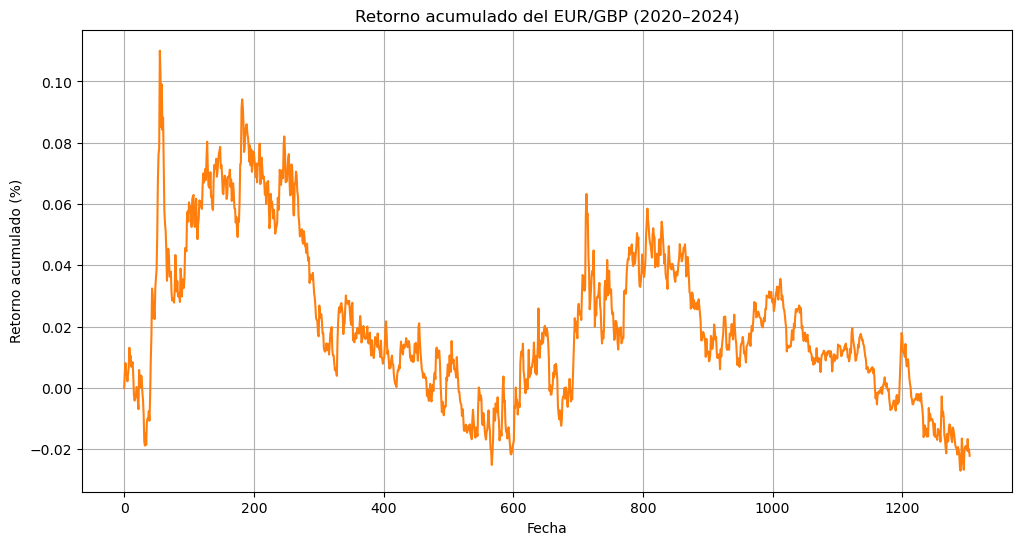

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["cum_return"], color="tab:orange")
plt.title("Retorno acumulado del EUR/GBP (2020–2024)")
plt.xlabel("Fecha")
plt.ylabel("Retorno acumulado (%)")
plt.grid(True)
plt.show()

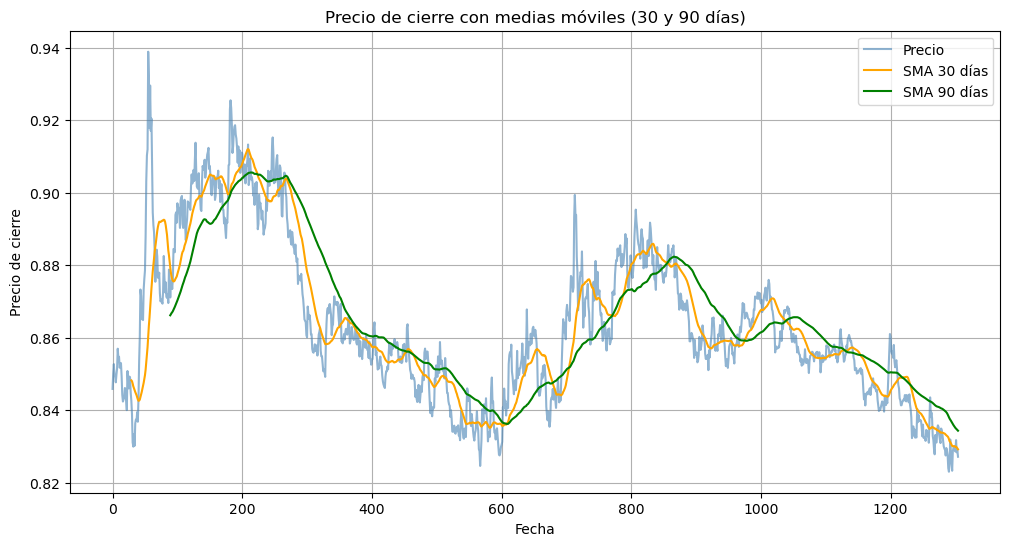

In [11]:
df["sma_30"] = df["close"].rolling(30).mean()
df["sma_90"] = df["close"].rolling(90).mean()

plt.figure(figsize=(12,6))
plt.plot(df.index, df["close"], label="Precio", color="steelblue", alpha=0.6)
plt.plot(df.index, df["sma_30"], label="SMA 30 días", color="orange")
plt.plot(df.index, df["sma_90"], label="SMA 90 días", color="green")
plt.title("Precio de cierre con medias móviles (30 y 90 días)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()
plt.grid(True)
plt.show()

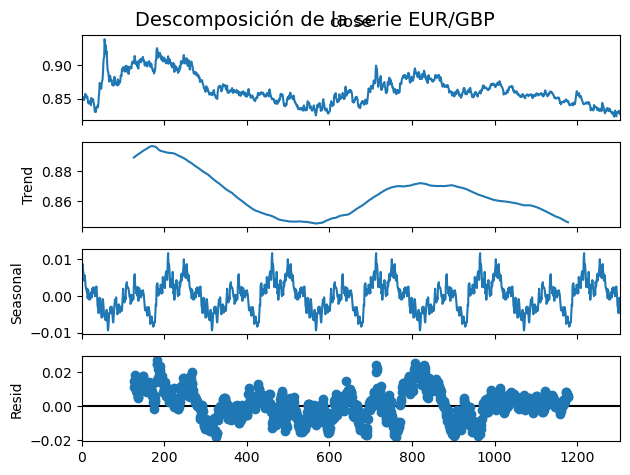

In [12]:
decomp = seasonal_decompose(df["close"], model="additive", period=252)
decomp.plot()
plt.suptitle("Descomposición de la serie EUR/GBP", fontsize=14)
plt.show()

<Figure size 1200x400 with 0 Axes>

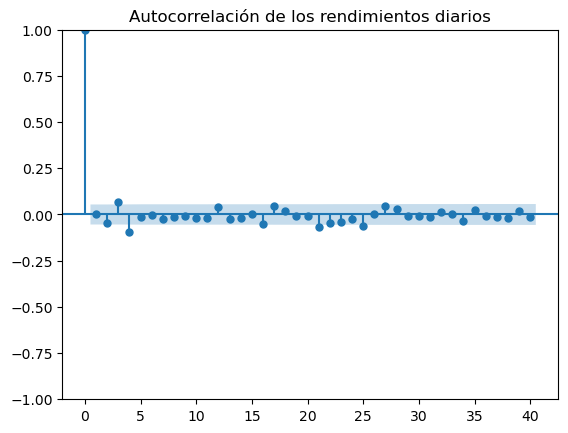

<Figure size 1200x400 with 0 Axes>

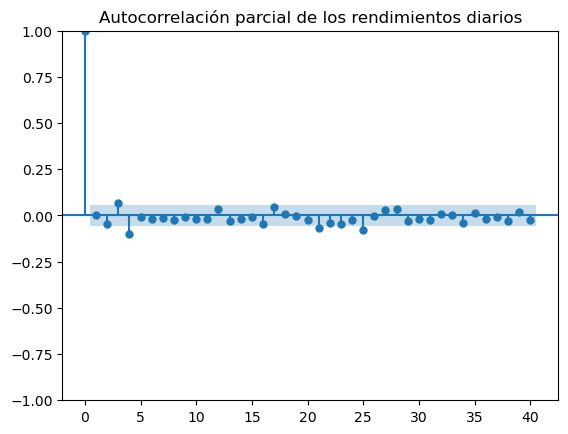

In [13]:
plt.figure(figsize=(12,4))
plot_acf(df["return"].dropna(), lags=40)
plt.title("Autocorrelación de los rendimientos diarios")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(df["return"].dropna(), lags=40, method="ywm")
plt.title("Autocorrelación parcial de los rendimientos diarios")
plt.show()

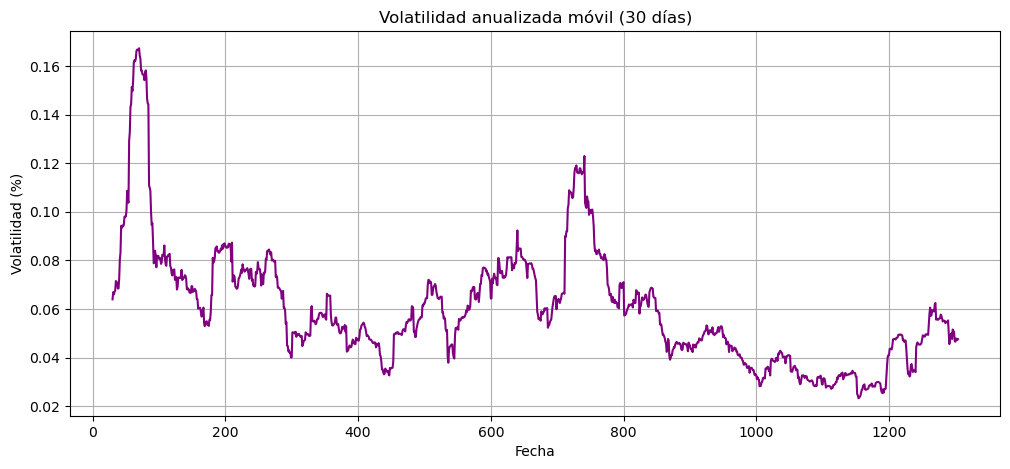

In [14]:
df["rolling_vol"] = df["return"].rolling(30).std() * np.sqrt(252)

plt.figure(figsize=(12,5))
plt.plot(df.index, df["rolling_vol"], color="purple")
plt.title("Volatilidad anualizada móvil (30 días)")
plt.xlabel("Fecha")
plt.ylabel("Volatilidad (%)")
plt.grid(True)
plt.show()

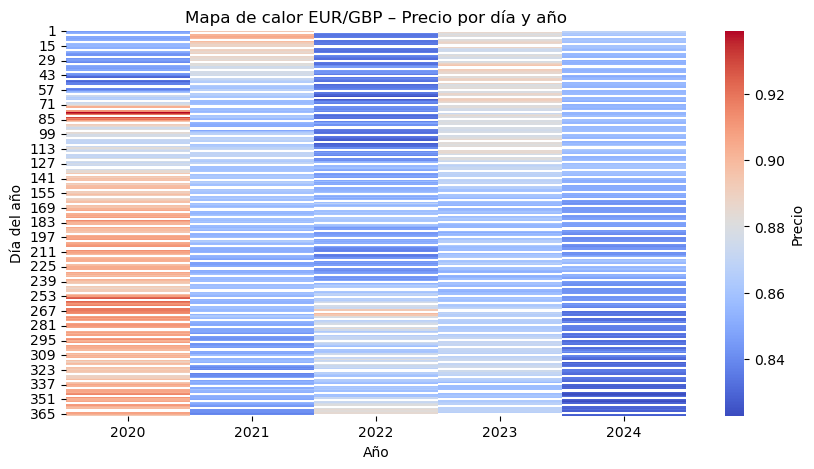

In [15]:
pivot = df.pivot_table(values="close", index="day_of_year", columns="year")
plt.figure(figsize=(10,5))
sns.heatmap(pivot, cmap="coolwarm", cbar_kws={'label': 'Precio'})
plt.title("Mapa de calor EUR/GBP – Precio por día y año")
plt.xlabel("Año")
plt.ylabel("Día del año")
plt.show()

#### 📊 Análisis Integral del Par EUR/GBP (2020–2024)

1. Visión General

El análisis del tipo de cambio **EUR/GBP** entre 2020 y 2024 revela una evolución marcada por una **alta volatilidad inicial** (pandemia y Brexit) seguida de una **estabilización progresiva** y una **tendencia descendente**.  
Esto indica una **apreciación moderada de la libra esterlina (GBP)** frente al euro (EUR) a lo largo del quinquenio.

---

2. Evolución Temporal y Patrones Anuales

**Gráfico:** Evolución diaria del EUR/GBP por año (2020–2024).  

**Observaciones:**
- **2020:** año más volátil, con picos por encima de 0.92 durante la pandemia y la incertidumbre del Brexit.  
- **2021–2024:** estabilidad creciente, con valores convergentes hacia 0.83–0.86.  
- **Tendencia general:** caída progresiva del tipo de cambio → fortalecimiento de la libra.  

**Conclusión:**  
El mercado se movió de un régimen de **alta incertidumbre** a uno de **mayor estabilidad**, con **volatilidad decreciente** y **apreciación sostenida** de GBP.

---

3. Serie Temporal Completa y Volumen Proxy

**Gráfico:** Dos subplots: cierre diario (arriba) y rango diario (high–low) como proxy de volatilidad (abajo).  

**Hallazgos:**
- Tres oscilaciones principales:
  - Subida en 2020 (pandemia).  
  - Descenso entre 2021–2022.  
  - Picos transitorios en 2023 y caída sostenida en 2024.  
- El rango diario muestra picos claros en 2020 y comienzos de 2023, asociados a eventos macroeconómicos.  

**Conclusión:**  
La **volatilidad es episódica**, intensificándose en crisis y reduciéndose en años de normalidad. El mercado se estabiliza gradualmente tras 2021.

---

4. Retorno Acumulado y Rendimientos

**Gráfico:** Retorno acumulado diario (2020–2024).  

**Observaciones:**
- Tendencia general **a la baja** con dos picos de ganancia:
  - Día ~50 (marzo 2020, inicio pandemia).  
  - Día ~700 (finales de 2022).  
- Retorno final negativo en 2024.  

**Conclusión:**  
El par mostró un **sesgo bajista persistente**, afectado por presiones macroeconómicas, con fases cortas de recuperación.

---

5. Promedio Anual y Distribución

**Gráficos:**  
- Barras del promedio anual.  
- Boxplot por año del precio de cierre.  

**Resultados:**
- Promedio anual descendente: **0.89 (2020) → 0.85 (2024)** (~4% de diferencia).  
- 2020 presenta la mayor dispersión y outliers.  
- Rango interanual decreciente → menor volatilidad.  

**Conclusión:**  
Confirmación cuantitativa de la **apreciación gradual de GBP** y la **reducción de la volatilidad**.

---

6. Correlación entre Precios OHLC

**Mapa de calor:**  
- Correlaciones > 0.98 entre open, high, low y close.  

**Interpretación:**  
El EUR/GBP presenta **movimientos intradía coherentes**, sin distorsiones. Ideal para modelado técnico, ya que las variables OHLC contienen información redundante.

---

7. Descomposición de la Serie Temporal

**Componentes:**
- **Tendencia:** bajista, coherente con retorno acumulado.  
- **Estacionalidad:** débil pero detectable (~200 días).  
- **Residuo:** ruido estable, sin outliers posteriores a 2020.  

**Conclusión:**  
La estacionalidad es limitada, aunque puede aprovecharse mediante variables temporales (mes, trimestre, día de la semana).

---

8. Autocorrelación de Rendimientos

**ACF (lags 1–40):**  
No hay correlación significativa → los rendimientos diarios se comportan como **ruido blanco**.

**Implicación:**  
Modelos puramente autorregresivos no tendrán buen desempeño. Se deben incluir **indicadores técnicos y variables de contexto**.

---

9. Volatilidad Anualizada Móvil (30 días)

**Gráfico:** Volatilidad móvil anualizada (30d).  

**Patrones:**
- Máximo en marzo 2020.  
- Picos intermedios en 2023.  
- Tendencia moderadamente al alza al cierre de 2024.  

**Conclusión:**  
La volatilidad es **heterocedástica**, variando con el tiempo. Estos cambios anticipan movimientos fuertes y son útiles para la predicción.

---

10. Conclusión Global

| Aspecto | Observación | Interpretación |
|----------|--------------|----------------|
| **Tendencia general** | Descendente (2020–2024) | Apreciación de la libra (GBP) |
| **Volatilidad** | Alta en 2020, moderada después | Crisis → estabilización |
| **Estacionalidad** | Débil, cíclica cada ~200 días | Influencia macroeconómica |
| **Estructura OHLC** | Alta correlación interna | Movimiento técnico limpio |
| **Distribución** | Rango decreciente | Mercado más eficiente y estable |
| **Autocorrelación** | Ausente | Rendimientos ≈ ruido blanco |

---

11. Implicaciones para Modelado Predictivo



Features clave

| Tipo | Variables sugeridas |
|------|---------------------|
| **Técnicas** | `SMA_30`, `SMA_90`, `SMA_crossover`, `RSI`, `ATR`, `volatility_30d` |
| **Temporales** | `month`, `quarter`, `day_of_week`, `is_month_end` |
| **Relacionales** | `sma_ratio`, `return_t`, `volatility_rolling` |

Target y métricas
- **Target:** Clasificación ternaria (`up`, `down`, `neutral`) con umbral ±0.1%.  
- **Métricas:** `balanced_accuracy_score`, `F1-macro` (por desbalance de clases).  
- **Validación:** Entrenamiento con 2020–2023, validación con 2024.

---

 12. Síntesis Final

- **El par EUR/GBP** ha transitado de una **fase volátil e incierta (2020)** hacia un **mercado más estable y predecible (2022–2024)**.  
- La **tendencia bajista** refleja el **fortalecimiento estructural de la libra**.  
- **No existe autocorrelación significativa**, lo que limita la predicción basada solo en rendimientos.  
- **Indicadores técnicos y temporales** aportan la señal más útil para modelado supervisado.  

**Conclusión General:**  
> El EUR/GBP es un mercado estable en el mediano plazo, con fases de volatilidad que responden a eventos macro.  
> Su comportamiento técnico limpio y su estructura temporal lo convierten en un candidato adecuado para estrategias basadas en *features engineered*, más que en pura dinámica autorregresiva.
